In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import json
import numpy as np
import os
import pandas as pd
from scipy.interpolate import make_interp_spline
import sys

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
from multiplex import drawable

data = os.path.join(os.getcwd(), '../data/dataset-statistics-uk-election.csv')

In [2]:
df = pd.read_csv(data)
df = df.drop(df.columns[-1], axis=1) # remove the last column, used for notes
df = df.drop(index=df.iloc[-3:].index, axis=1)
df.Notes = None
df.Date = pd.to_datetime(df.Date)
df.Time = pd.to_datetime(df.Time, format='%H:%M').dt.hour
df.Size = df.Size.apply(lambda x: x.replace(',', ''))
df.Size = df.Size.astype(int)
df = df[df.Date < datetime(2022, 9, 11)] # remove the last day
df

,Dataset,Date,Time,Size,Keywords,Notes
0,20220904-13,2022-09-04,13,16427,"Truss, Sunak",None
1,20220904-14,2022-09-04,14,15824,"Truss, Sunak",None
2,20220904-15,2022-09-04,15,14066,"Truss, Sunak",None
3,20220904-16,2022-09-04,16,12864,"Truss, Sunak",None
4,20220904-17,2022-09-04,17,13018,"Truss, Sunak",None
...,...,...,...,...,...,...
150,20220910-19,2022-09-10,19,6077,"Truss, Starmer",None
151,20220910-20,2022-09-10,20,5606,"Truss, Starmer",None
152,20220910-21,2022-09-10,21,6110,"Truss, Starmer",None
153,20220910-22,2022-09-10,22,6217,"Truss, Starmer",None


In [3]:
# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 2, 'with_legend': True,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 12, 
                 'markeredgewidth': 2, 'markeredgecolor': 'C4' }
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'alpha': 0.8, 'pad': 0,
                     'align': 'left', 'va': 'top', 'facecolor': '#ffffff99' }

In [4]:
df.loc[24, 'Notes'] = 'Truss wins election'
df.loc[48, 'Notes'] = 'Truss appointed PM'
df.loc[55, 'Notes'] = 'Cabinet appointed'
df.loc[72, 'Notes'] = 'First PQ session'
df.loc[95, 'Notes'] = 'Energy bill reform'
df.loc[102, 'Notes'] = 'Queen Elizabeth II passes away'
df.loc[120, 'Notes'] = 'Tributes to Queen'
df.loc[124, 'Notes'] = 'King Charles III meets Truss'
df.loc[141, 'Notes'] = 'Accession Council'

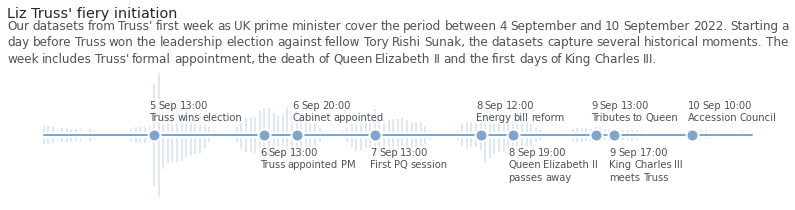

In [5]:
# draw the visualization
figure = plt.figure(figsize=(14, 2.5))
viz = drawable.Drawable(figure)

# draw the background
x, y = df.index, df.Size
y = y / y.max()
spline = make_interp_spline(x, y)
_x = np.linspace(x.min(), x.max(), 500)
_y = spline(_x)
# viz.fill_between(_x, _y, -_y, color='C1', alpha=0.25, linewidth=0)
# viz.fill_between(_x, _y, -_y, color='C4', alpha=0.5, linewidth=0, hatch='|||', edgecolor='C1')
viz.bar(x, y, color='C1', alpha=0.25, align='center', width=0.4)
viz.bar(x, -y, color='C1', alpha=0.25, align='center', width=0.4)

# draw the foreground
viz.draw_time_series(df.index, [ 0 ] * len(df), color='C1', **style)

# draw the annotations
annotation_style['va'] = 'top'
for i, row in df[~df.Notes.isna()].iterrows():
    viz.plot(i, 0, color='C1', **marker_style)
    annotation_style['va'] = 'top' if annotation_style['va'] == 'bottom' else 'bottom'
    pos_x = (i - 1, i + 20)
    if annotation_style['va'] == 'top':
        offset_y = -0.2
        viz.annotate(f"{ row.Date.strftime('%-d %b') } { row.Time }:00", pos_x, 0 + offset_y, **annotation_style)
        viz.annotate(row.Notes, pos_x, 0 + offset_y * 2, **annotation_style)
    else:
        offset_y = 0.2
        viz.annotate(f"{ row.Date.strftime('%-d %b') } { row.Time }:00", pos_x, 0 + offset_y * 2, **annotation_style)
        viz.annotate(row.Notes, pos_x, 0 + offset_y, **annotation_style)

viz.axis(False)
xlim = viz.get_xlim()
viz.set_xlim(xlim[0], max(xlim[1], df[~df.Notes.isna()].index.max() + 20))
viz.set_title("Liz Truss' fiery initiation", loc='left')
viz.set_caption(f"""Our datasets from Truss' first week as UK prime minister cover the period between { df.iloc[0].Date.strftime("%-d %B") } and { df.iloc[-1].Date.strftime("%-d %B %Y") }.
                    Starting a day before Truss won the leadership election against fellow Tory Rishi Sunak, the datasets capture several historical moments.
                    The week includes Truss' formal appointment, the death of Queen Elizabeth II and the first days of King Charles III.""",
                align='justify')
viz.savefig('../exports/7.3-timeline.png', dpi=300, bbox_inches='tight')